## EMA + BOLL
当股价突破布林带中轨（即20日EMA附近）并伴随放量，可能是趋势启动信号。
当股价触及布林带上轨且EMA乖离过大，短期可能有回调风险。

In [14]:
# 获取数据源
import baostock as bs
import pandas as pd
import logging
import numpy as np

def get_k_data(code, start, end):
    lg = bs.login()
    # 显示登陆返回信息
    logging.info('login respond error_code:' + lg.error_code)
    logging.info('login respond  error_msg:' + lg.error_msg)
    # 获取股票数据
    rs = bs.query_history_k_data_plus(code,
                                              "date,open,high,low,close,volume",
                                              start_date=start,
                                              end_date=end,
                                              frequency="d",
                                              adjustflag="3")  # adjustflag="3"表示不复权
    data = rs.get_data()


    # 登出baostock系统
    bs.logout()

    # 创建DataFrame
    df = data[['date', 'open', 'high', 'low', 'close', 'volume']].rename(columns={'date': 'Date'})

    # 转换日期格式
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)  # 设置日期列为索引

    # 将空字符串替换为 NaN
    df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].replace('', np.nan)
    # 去除包含空值的行
    df = df.dropna(subset=['open', 'high', 'low', 'close', 'volume'])

    # 将股价数据转换为数值类型
    df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    return df

In [15]:
stock_code = "sh.603486"  
start_date = "2024-01-01"
end_date = "2025-12-31"

df = get_k_data(stock_code, start_date, end_date)

login success!
logout success!


In [16]:
import talib
import mplfinance as mpf
import matplotlib.pyplot as plt

# 计算 Bollinger Bands，默认参数20日均线，2倍标准差
df['upperband'], df['middleband'], df['lowerband'] = talib.BBANDS(df['close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)


#下面是一个示例代码，展示如何根据以下条件：
# 1. 今日收盘价由下穿转为上穿布林带中轨（即20日中轨）；
# 2. 今日成交量大于过去20日成交量均值的1.5倍（即放量），

# 计算20日成交量均值
df['vol_avg20'] = df['volume'].rolling(window=20).mean()

# 判断是否突破中轨：昨天收盘价低于中轨，今天收盘价高于中轨
condition_price = (df['close'].shift(1) < df['middleband'].shift(1)) & (df['close'] > df['middleband'])
# 判断是否成交量放大：今天成交量大于20日均量的1.5倍
condition_volume = (df['volume'] > 1.5 * df['vol_avg20'])

# 当两者同时满足时，用今日收盘价作为标记点，否则取NaN
df['trend_start_signal'] = np.where(condition_price & condition_volume, df['close'], np.nan)


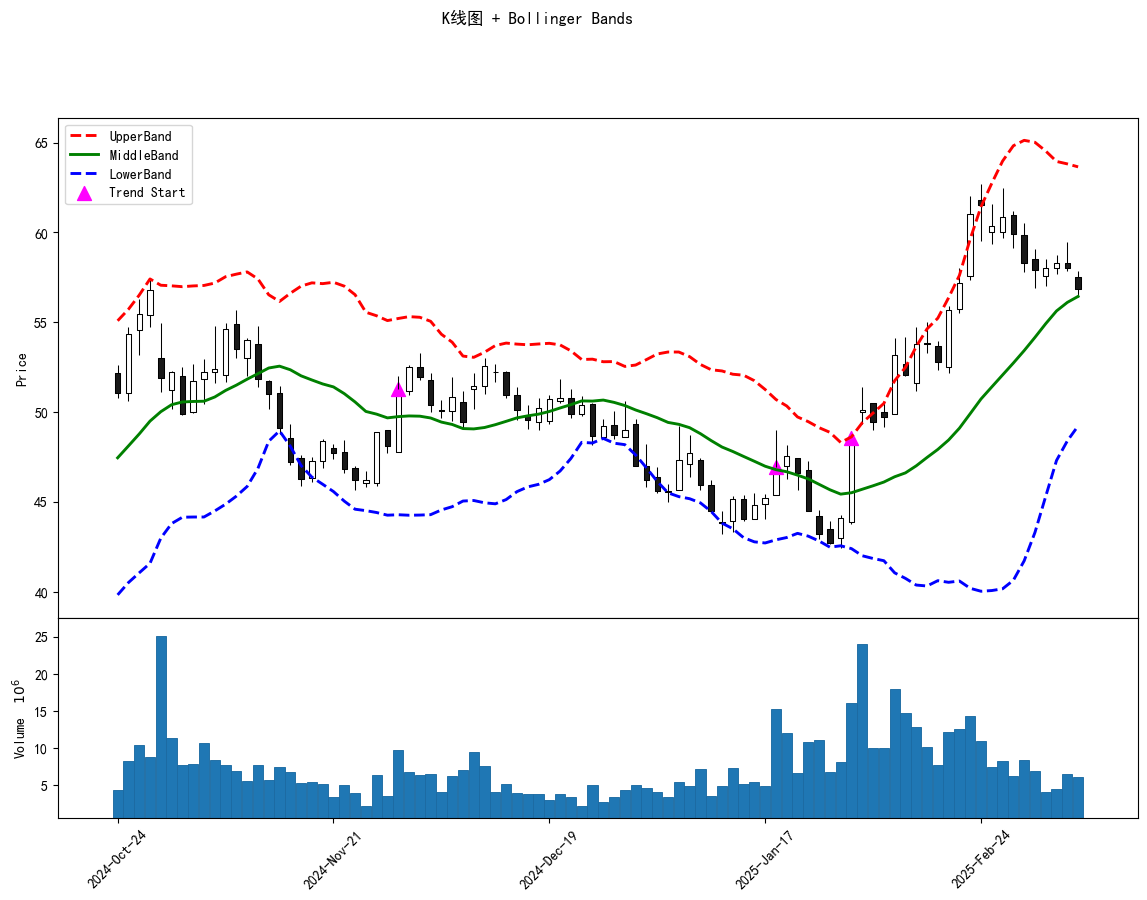

In [17]:
df = df.tail(90)  # 只显示最近90个交易日的数据

# 使用 make_addplot 添加 Bollinger Bands
ap_upper = mpf.make_addplot(df['upperband'], panel=0, color='red', linestyle='--', label='UpperBand')
ap_middle = mpf.make_addplot(df['middleband'], panel=0, color='green', linestyle='-', label='MiddleBand')
ap_lower = mpf.make_addplot(df['lowerband'], panel=0, color='blue', linestyle='--', label='LowerBand')

# 添加趋势启动信号，使用散点图标记（例如向上箭头）
ap_signal = mpf.make_addplot(df['trend_start_signal'], panel=0, type='scatter', markersize=100, marker='^', color='magenta', label='Trend Start')


# 创建自定义风格，设置中文字体
my_style = mpf.make_mpf_style(rc={'font.sans-serif': ['SimHei'],
                                  'axes.unicode_minus': False})

aps = [ap_upper, ap_middle, ap_lower,ap_signal]
# 绘制 K 线图并叠加 Bollinger Bands
mpf.plot(df, type='candle', style=my_style, addplot=aps, volume=True, figsize=(15,10), title="K线图 + Bollinger Bands")
plt.show()